# Chest X-Ray Images classification

## 1. Introduction
Basing on image and patient data we want to classify into one or multiple classes

## 2. Data
We're working on dataset from Kaggle https://www.kaggle.com/nih-chest-xrays/data.
This NIH Chest X-ray Dataset comprises 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

### Data limitations:
The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation
### Class descriptions
There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

Atelectasis
Consolidation
Infiltration
Pneumothorax
Edema
Emphysema
Fibrosis
Effusion
Pneumonia
Pleural_thickening
Cardiomegaly
Nodule Mass
Hernia

In [23]:
import numpy as np
import os
import pandas as pd
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
def plot_bar(x, y, title, y_label="Count", x_label=""):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    sns.barplot(x=x, y=y, alpha=1)

In [25]:
image_paths = pd.DataFrame(glob("data/images_*/images/*.png"), columns=["path"])
image_paths["Image Index"] = image_paths["path"].apply(lambda x: x.split("/")[-1])

In [26]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
# join image_paths with all_xray_df on "Image Index"
all_xray_df = all_xray_df.merge(image_paths, on="Image Index", how="left")
all_xray_df.drop(columns=["Unnamed: 11", "OriginalImagePixelSpacing[x", "y]", "OriginalImage[Width", "Height]"], inplace=True)

In [27]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,data/images_001/images/00000003_000.png


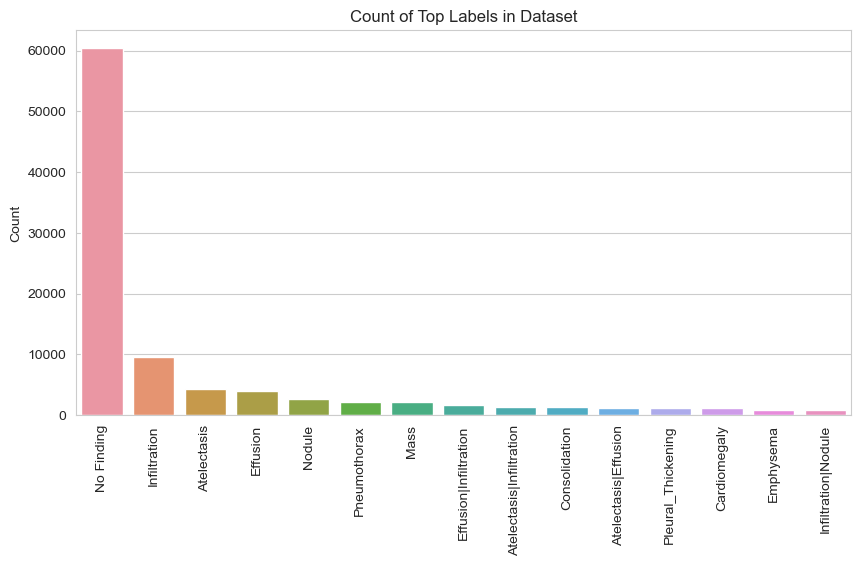

In [28]:

multiclass_counts = all_xray_df['Finding Labels'].value_counts()
multilabel_counts = multiclass_counts[:15]

plot_bar(multilabel_counts.index, multilabel_counts.values, "Count of Top Labels in Dataset")

In [29]:
multilabel_counts.index = multilabel_counts.index.map(lambda x: x.replace('No Finding', ''))

In [30]:


# Define the class labels in a sorted set
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [31]:
list(enumerate(all_xray_df.columns))

[(0, 'Image Index'),
 (1, 'Finding Labels'),
 (2, 'Follow-up #'),
 (3, 'Patient ID'),
 (4, 'Patient Age'),
 (5, 'Patient Gender'),
 (6, 'View Position'),
 (7, 'path'),
 (8, 'Atelectasis'),
 (9, 'Cardiomegaly'),
 (10, 'Consolidation'),
 (11, 'Edema'),
 (12, 'Effusion'),
 (13, 'Emphysema'),
 (14, 'Fibrosis'),
 (15, 'Hernia'),
 (16, 'Infiltration'),
 (17, 'Mass'),
 (18, 'Nodule'),
 (19, 'Pleural_Thickening'),
 (20, 'Pneumonia'),
 (21, 'Pneumothorax')]

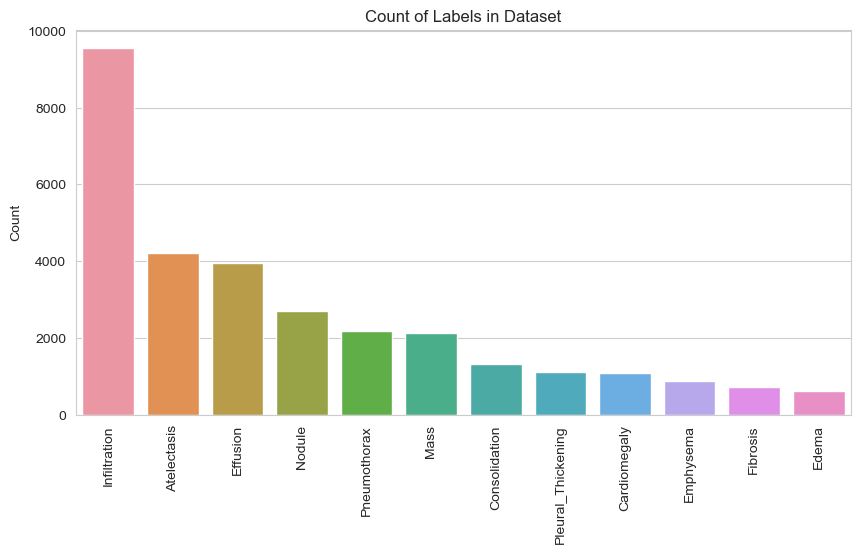

In [32]:
columns = all_xray_df.columns[8:22]
all_xray_df = all_xray_df[all_xray_df[columns].values.sum(axis=1) == 1]

COUNT_THRESHOLD = 500
# select from all_xray_df where there's more than 500 of a 'disease_vec'
all_xray_df = all_xray_df[all_xray_df['Finding Labels'].map(all_xray_df['Finding Labels'].value_counts()) > COUNT_THRESHOLD]
all_labels = all_xray_df['Finding Labels'].unique()
disease_counts = all_xray_df['Finding Labels'].value_counts()
all_xray_df['disease_vec'] = all_xray_df[all_labels].apply(lambda x: tuple(x.values), axis=1)
plot_bar(disease_counts.index, disease_counts.values, "Count of Labels in Dataset")

In [33]:
vec_counts = all_xray_df['disease_vec'].value_counts()
weights = np.array([1 / np.power(v, 2/3) for v in vec_counts.values])
weights = weights / weights.sum()
weights = dict(zip(vec_counts.index, weights))

In [34]:
all_xray_df['weights'] = all_xray_df['disease_vec'].map(lambda x: weights[x])

In [35]:
all_xray_df = all_xray_df.sample(40000, weights='weights', replace=True)

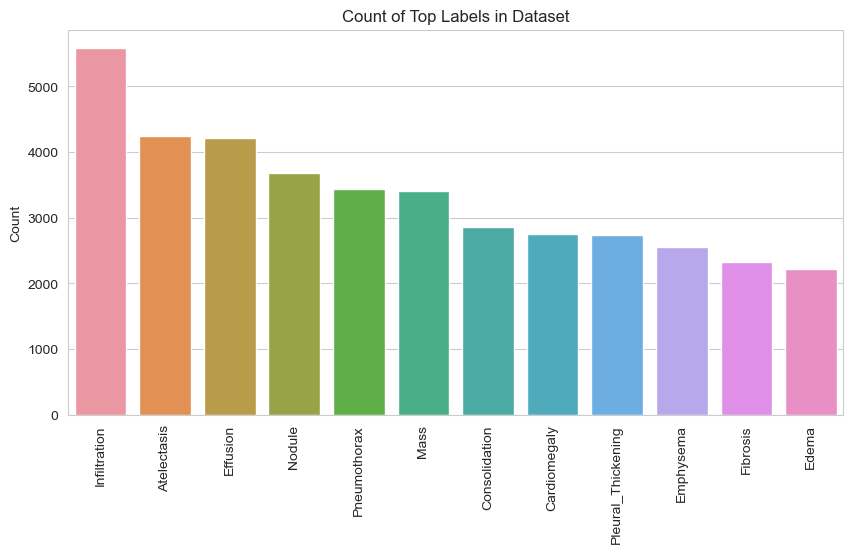

In [36]:
vec_counts = all_xray_df['Finding Labels'].value_counts().sort_values(ascending=False)
plot_bar(vec_counts.index, vec_counts.values, "Count of Top Labels in Dataset")

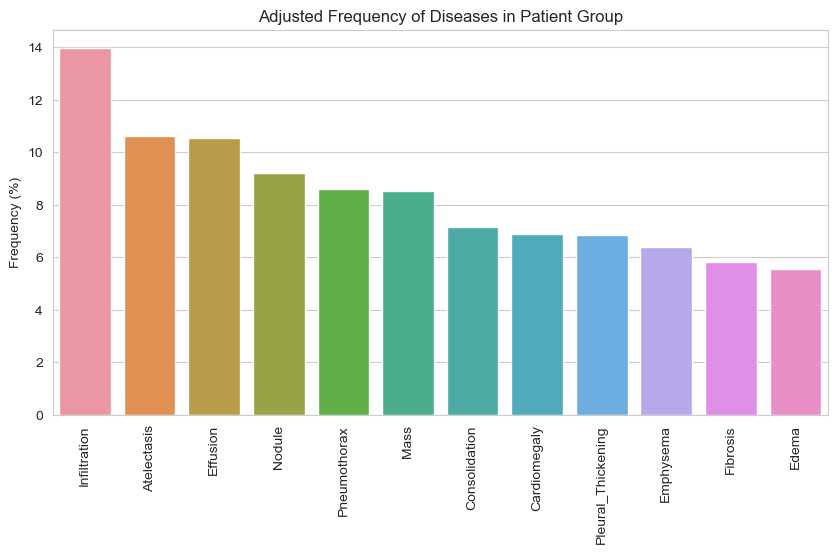

In [37]:
multilabel_counts = 100 * np.mean(all_xray_df[all_labels].values, axis=0)
l_value_counts = sorted(zip(all_labels, multilabel_counts), key=lambda x: x[1], reverse=True)

plot_bar([v[0] for v in l_value_counts], [v[1] for v in l_value_counts], "Adjusted Frequency of Diseases in Patient Group", y_label="Frequency (%)")

In [38]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                      test_size = 0.25,
                                      random_state = 2018,
                                      stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

# select 'disease_vec' from row 0
len(train_df.iloc[0]['disease_vec'])


train 30000 validation 10000


12

In [39]:
path = os.getcwd()

In [40]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
BATCH_SIZE = 30
VALID_BATCH_SIZE = 250
TEST_BATCH_SIZE = 1000
STEPS_PER_EPOCH = 100
COLOR_CHANNELS = 1

# this is the augmentation configuration we will use for training
# convert to float32, rescale to [0,1] and normalize to mean 0 and std 1

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [62]:
import tensorflow as tf
# define cmap that converts color_mode to channel count
clr_mode = {1: 'grayscale', 3: 'rgb'}

# def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=(128, 128), color_mode='rgb', batch_size=32, shuffle=False, seed=None):
def dataset_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=IMG_SIZE, color_channels=COLOR_CHANNELS, batch_size=BATCH_SIZE, seed=None):
    df_gen = img_data_gen.flow_from_dataframe(
        in_df, directory=os.getcwd(),
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',
        batch_size=batch_size,
        target_size=target_size,
        color_mode=clr_mode[color_channels],
        shuffle=True,
        repeat=True,
        seed=seed
    )

    # Convert to a tf.data.Dataset object
    def data_generator():
        while True:
            x, y = next(df_gen)
            yield x, np.vstack(y)


    train_ds = tf.data.Dataset.from_generator(data_generator,
                                              output_signature=(
                                                    tf.TensorSpec(shape=(batch_size, *target_size, color_channels), dtype=tf.float32),
                                                    tf.TensorSpec(shape=(batch_size, len(all_labels)), dtype=tf.float32)))

    return train_ds


In [63]:
train_ds = dataset_from_dataframe(core_idg, train_df,
                                  path_col = 'path',
                                  y_col = 'disease_vec',
                                  target_size = IMG_SIZE,
                                  color_channels=COLOR_CHANNELS,
                                  batch_size = BATCH_SIZE)
valid_ds = dataset_from_dataframe(core_idg, valid_df,
                                  path_col = 'path',
                                  y_col = 'disease_vec',
                                  target_size = IMG_SIZE,
                                  color_channels=COLOR_CHANNELS,
                                  batch_size = VALID_BATCH_SIZE) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_ds = dataset_from_dataframe(core_idg, valid_df,
                                 path_col = 'path',
                                 y_col = 'disease_vec',
                                 target_size = IMG_SIZE,
                                 color_channels=COLOR_CHANNELS,
                                 batch_size = TEST_BATCH_SIZE) # one big batch

X_test, y_test = next(iter(test_ds))

Found 30000 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


In [43]:
X_test.shape, y_test.shape, STEPS_PER_EPOCH

(TensorShape([1000, 128, 128, 1]), TensorShape([1000, 12]), 100)

In [64]:
LOAD_MODEL = True

## Creating model

from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

multi_disease_model = None

base_model = MobileNet(input_shape =  (*IMG_SIZE, COLOR_CHANNELS),
                       include_top = False, weights = None)
# model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# resnet = hub.KerasLayer(model_url, input_shape=(*IMG_SIZE, COLOR_CHANNELS), trainable=False)
multi_disease_model = Sequential()
multi_disease_model.add(base_model)
# multi_disease_model.add(resnet)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512, activation = 'relu'))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
if LOAD_MODEL:
    multi_disease_model.load_weights('/Users/blazej.przybyszewski/Desktop/src/chest-xray-classification/xray_class_weights.best.hdf5')

multi_disease_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'binary_crossentropy',
                        metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 12)               

In [65]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1,
                        min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [rlr, checkpoint, early]

In [66]:
multi_disease_model.fit(train_ds,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data = (X_test, y_test),
                        epochs = 1,
                        callbacks = callbacks_list)

2023-02-20 09:15:10.010839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.2836 - binary_accuracy: 0.9166 - mae: 0.1518

2023-02-20 09:15:40.405844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.30755, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 33s 307ms/step - loss: 0.2836 - binary_accuracy: 0.9166 - mae: 0.1518 - val_loss: 0.3075 - val_binary_accuracy: 0.9167 - val_mae: 0.1412 - lr: 0.0010


In [67]:
y_preds = multi_disease_model.predict(X_test, batch_size = 32, verbose = True)

2023-02-20 09:15:57.004805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 23ms/step


TypeError: Neither the `x` nor `y` variable appears to be numeric.

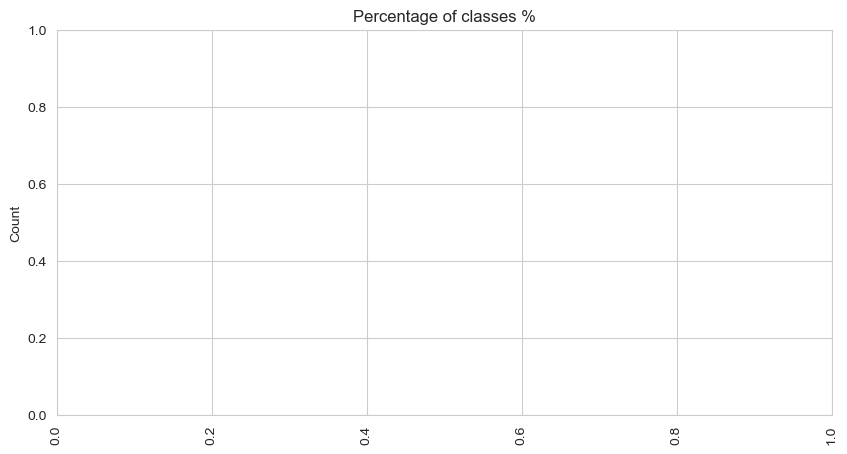

In [68]:
sorted_predict = sorted(zip(all_labels, 100 * np.mean(y_test, axis=0)), key=lambda x: x[1], reverse=True)


plot_bar([v[0] for v in sorted_predict], [v[1] for v in sorted_predict], 'Percentage of classes %')


In [69]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# get np array of test_y
Y_test = y_test.numpy()

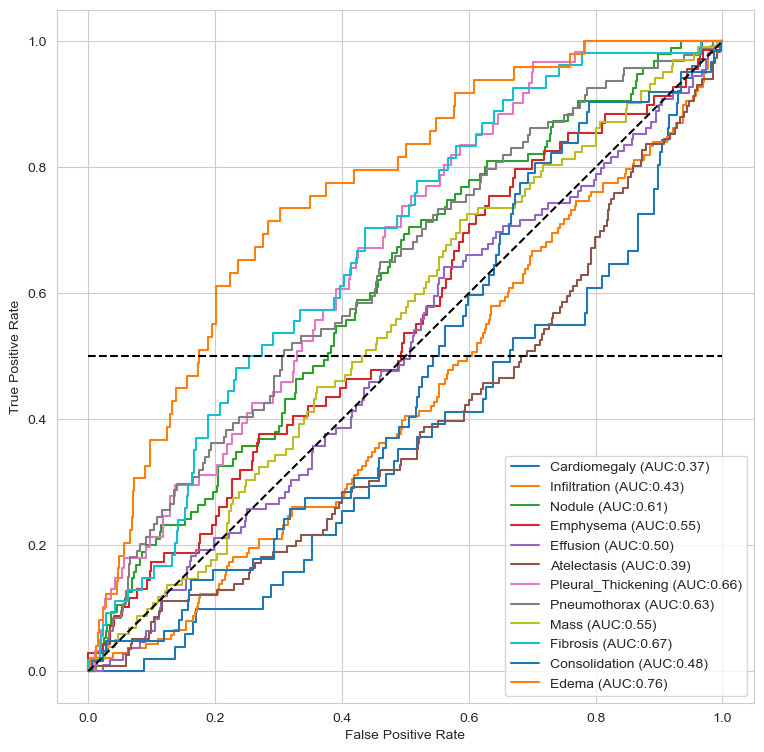

In [70]:
def plot_roc_curve(test_Y, pred_y, all_labels):
    from sklearn.metrics import roc_curve, auc
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    # add threshold line at y=0.5
    c_ax.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')
    # add black line y=x
    c_ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    fig.savefig('barely_trained_net.png')

plot_roc_curve(Y_test, y_preds, all_labels)

# Continued training

In [71]:
multi_disease_model.fit(train_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        validation_data =  (X_test, y_test),
                        epochs = 10,
                        callbacks = [rlr, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2801 - binary_accuracy: 0.9167 - mae: 0.1508
Epoch 1: val_loss improved from 0.30755 to 0.29180, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 30s 300ms/step - loss: 0.2801 - binary_accuracy: 0.9167 - mae: 0.1508 - val_loss: 0.2918 - val_binary_accuracy: 0.9167 - val_mae: 0.1539 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2793 - binary_accuracy: 0.9167 - mae: 0.1507
Epoch 2: val_loss improved from 0.29180 to 0.28453, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 30s 298ms/step - loss: 0.2793 - binary_accuracy: 0.9167 - mae: 0.1507 - val_loss: 0.2845 - val_binary_accuracy: 0.9167 - val_mae: 0.1800 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2789 - binary_accuracy: 0.9166 - mae: 0.1504
Epoch 3: val_loss did not improve from 0.28453
100/100 [=============

32/32 [==============================] - 1s 20ms/step


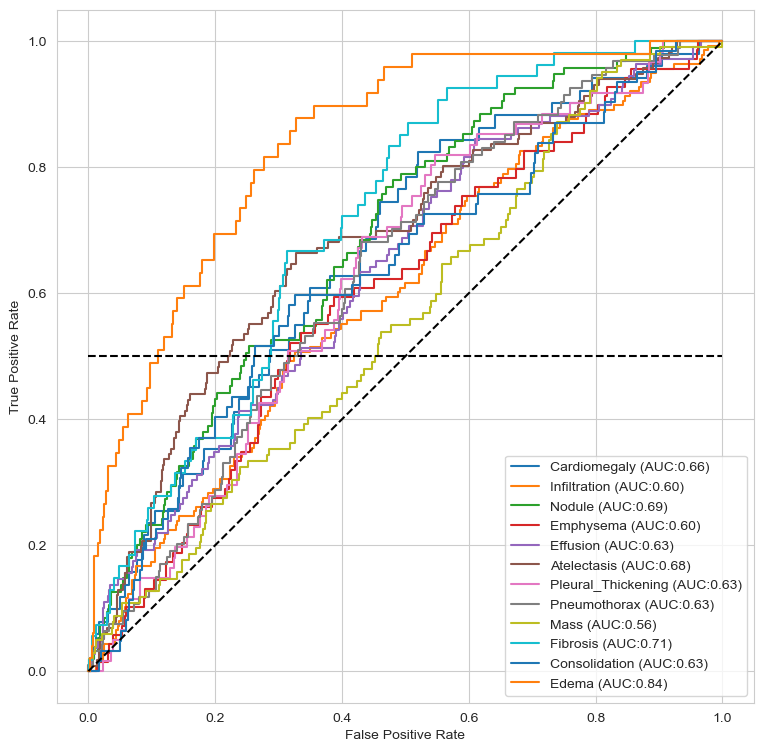

In [72]:
y_preds = multi_disease_model.predict(X_test, batch_size = 32, verbose = True)
Y_test = y_test.numpy()

plot_roc_curve(Y_test, y_preds, all_labels)

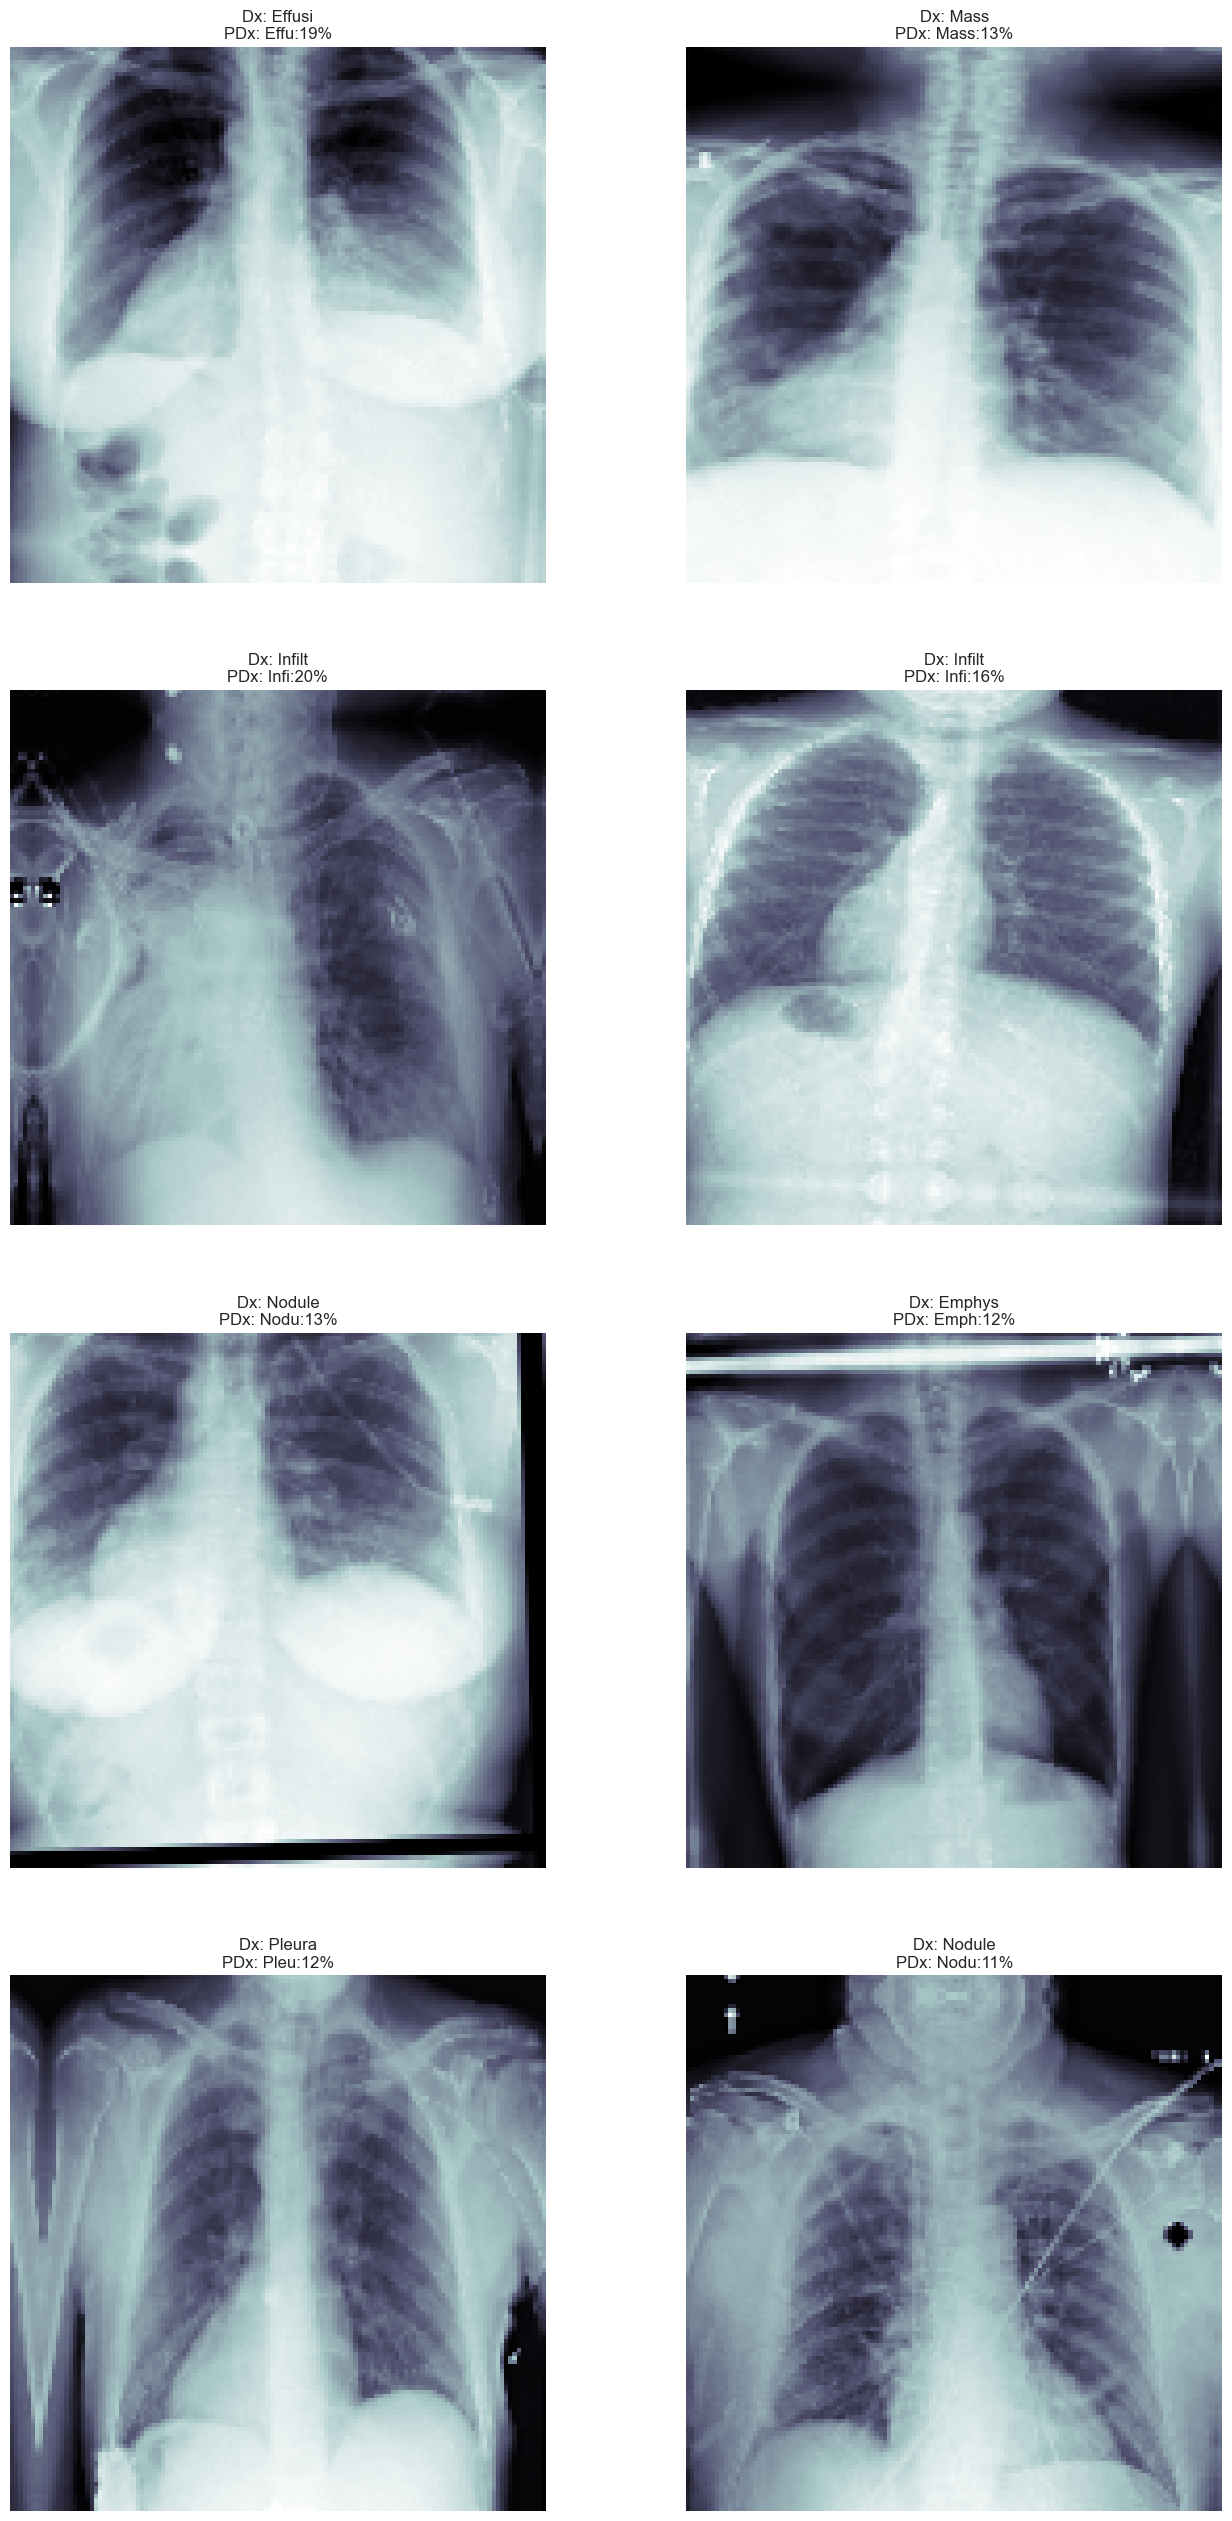

In [73]:
sickest_idx = np.argsort(np.sum(Y_test, 1) < 1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(X_test[idx, :, :, 0], cmap ='bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                        Y_test[idx])
                if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                                                Y_test[idx], y_preds[idx])
                if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [74]:
def get_pred_label(prediction_probabilities):
    """
    Turn an array of predictiona into breed
    """
    return all_labels[np.argmax(prediction_probabilities)]

# Get a predicted label
pred_label = get_pred_label(y_preds[81])
pred_label

'Infiltration'

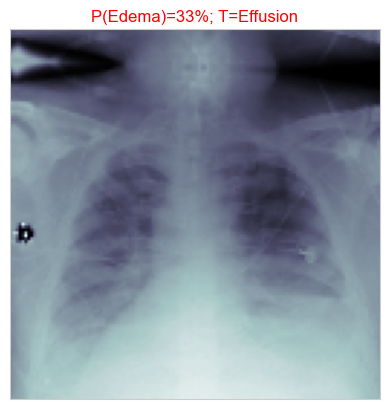

In [77]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n.
    """
    pred_prob, true_prob, image = prediction_probabilities[n], labels[n], images[n]
    pred_label = get_pred_label(pred_prob)
    true_label = get_pred_label(true_prob)

    # Plot image & remove ticks
    plt.imshow(image, cmap="bone")
    plt.xticks([])
    plt.yticks([])

    # Change plot title to be predicted, probability of prediction and truth label
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P({pred_label})={np.max(pred_prob)*100:2.0f}%; T={true_label}", fontsize=12, color=color)

plot_pred(y_preds, Y_test, X_test, 2)

In [93]:
IX = 4
yy = Y_test[IX].reshape(1, -1)
yy

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [94]:
pyy = y_preds[IX].reshape(1, -1)
pyy.argsort()

array([[11, 10,  3,  0,  4,  5,  8,  6,  9,  2,  7,  1]])

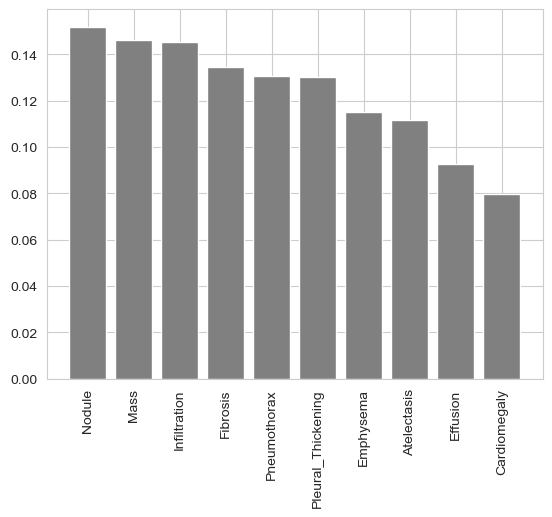

In [47]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], all_labels[labels[n].argmax()]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = all_labels[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # Change color of true label
    if true_label in top_10_pred_labels:
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

plot_pred_conf(prediction_probabilities=y_preds,
               labels=Y_test,
               n=2)

In [ ]:
# Let's check out a few predictions and their different values
offset = 0
num_rows = 20
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_rows):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=y_preds,
              labels=Y_test,
              images=X_test,
              n=i+offset)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=y_preds,
                   labels=Y_test,
                   n=i+offset)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

sum_y_pred = np.sum(y_preds > 0.25, 1)
sum_y_test = np.sum(Y_test, 1)

# plot confusion matrix with sns.heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(sum_y_test, sum_y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(sum_y_test, sum_y_pred))
plt.title(all_sample_title, size = 15);
fig.savefig('trained_img_confusion_matrix.png')


